In [31]:
import re
import os
import io
import ast
import gzip
import glob

import numpy as np
import pandas as pd

import torch
import pyro.distributions as dist

from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from path import Path

from tqdm.notebook import tqdm

In [2]:
latent_dim_dict = {
    'Arizona': 5, 
    'Atlanta': 7,
    'Baltimore': 15,
    'Buffalo': 25,
    'Carolina': 5, 
    'Chicago': 15,
    'Cincinnati': 13,
    'Cleveland': 11,
    'Dallas': 37,
    'Denver': 5,
    'Detroit': 12,
    'Green Bay': 52,
    'Houston': 12, 
    'Indianapolis': 10, 
    'Jacksonville': 12,
    'Kansas City': 11,
    'Las Vegas': 12,
    'LA Chargers': 5,
    'LA Rams': 10,
    'Miami': 8,
    'Minnesota': 5, 
    'New England': 9, 
    'New Orleans': 18 ,
    'NY Giants': 7,
    'NY Jets': 7,
    'Philadelphia': 10,
    'Pittsburgh': 25,
    'San Francisco': 12,
    'Seattle': 14,
    'Tampa Bay': 15,
    'Tennessee': 13,
    'Washington': 4
}

In [3]:
DATA_SUPDIR = Path('/net/projects/schein-lab/jshou/dat/')

def load_team_data(team, dat_supdir=DATA_SUPDIR):
    # load data
    train_pivot = pd.read_csv(dat_supdir.joinpath(team, 'train_pivot.csv'), index_col=0)
    test_pivot = pd.read_csv(dat_supdir.joinpath(team, 'test_pivot.csv'), index_col=0)

    # create a single pivot table for all outcomes
    total_pivot = pd.concat([train_pivot, test_pivot], axis=0)

    # this is a (timestep x county)-array of all outcomes
    all_outcomes_TN = total_pivot.values
    n_timesteps, n_counties = all_outcomes_TN.shape

    # names of the dates and counties
    dates = total_pivot.index
    county_names = total_pivot.columns

    # make sure that the last county is the stadium county
    assert county_names[-1] == 'Stadium_County'

    # the index of the intervention time
    intervention_t = train_pivot.values.shape[0]

    # make sure that the intervention time is correct
    assert np.allclose(all_outcomes_TN[:intervention_t], train_pivot.values)
    assert np.allclose(all_outcomes_TN[intervention_t:], test_pivot.values)

    return total_pivot, intervention_t

In [4]:
DATA_SUPDIR = Path('/net/projects/schein-lab/jshou/dat/')
RESULTS_SUPDIR = Path('/net/projects/schein-lab/jshou/Posterior_Checks/')
REPLICATION_SUPDIR = Path('/net/projects/schein-lab/jshou/replication/')

# this is where we will save all new plots
FIG_DIR = RESULTS_SUPDIR.joinpath('plots')

model = 'GAP'
reg_type = 'Ridge'
include_previous_outcome = True
teams = [team for team in latent_dim_dict.keys() if team != 'Arizona']

collected_teams = []
causal_effect_arrays = []
for team in tqdm(teams):
    # load data
    total_pivot, intervention_t = load_team_data(team)
    all_outcomes_TN = total_pivot.values
    n_timesteps, n_counties = all_outcomes_TN.shape

    # load counterfactuals
    latent_dim = latent_dim_dict[team]

    subdirs = [team, model, f'K_{latent_dim}', f'reg_type_{reg_type}', f'include_prev_{include_previous_outcome}']
    final_outdir = REPLICATION_SUPDIR.joinpath(*subdirs)
    counterfactual_preds_file = final_outdir.joinpath('counterfactuals.npy')
    if not counterfactual_preds_file.exists():
        continue
    
    counterfactual_preds = np.load(counterfactual_preds_file)
    causal_effects_ST = counterfactual_preds - all_outcomes_TN[intervention_t:, -1]
    causal_effect_arrays.append(causal_effects_ST)
    collected_teams.append(team)

  0%|          | 0/31 [00:00<?, ?it/s]

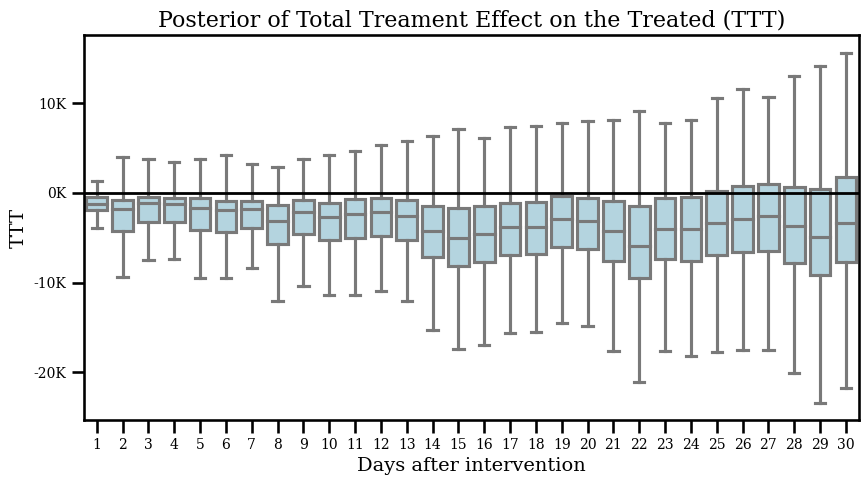

In [38]:
def compute_ATT(causal_effect_arrays):
    assert all(arr.shape[0] == 2000 for arr in causal_effect_arrays)
    shortest_window = min(arr.shape[1] for arr in causal_effect_arrays)
    causal_effect_arrays = np.array([arr[:, :shortest_window] for arr in causal_effect_arrays])
    total_effect_ST = causal_effect_arrays.sum(axis=0)
    return total_effect_ST

total_effect_ST = compute_ATT(causal_effect_arrays)

# box plots across time
# dont show points outside the whiskers

sns.set_context('talk')
# Enable LaTeX text rendering
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'

plt.figure(figsize=(10, 5))
sns.boxplot(data=total_effect_ST[:, :30], color='lightblue', showfliers=False)
plt.axhline(0, color='k', lw=2)
plt.xlabel('Days after intervention', fontsize=14)

ax = plt.gca()
def thousands_formatter(x, pos):
    return '%1.0fK' % (x*1e-3)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(thousands_formatter))
plt.xticks(np.arange(30), np.arange(1, 31), fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel('TTT', fontsize=14)
plt.title('Posterior of Total Treament Effect on the Treated (TTT)', fontsize=16)
plt.show()
# _ = plt.hist(total_effect_ST[:, 0], bins=50)